# 5900 Capstone Time Series Model - Exponential Smoothing Model - Sonus

### Step 1: load packages

In [2]:
# load packages
library(ggplot2);library(ggthemes);library(gridExtra);library(dygraphs) # For plots 
library(quantmod);library(xts);library(zoo) # For converting data into xts class objects
library(fpp); library(fpp2) # Datasets from Forecasting text by Rob Hyndman
library(tseries) # for a statistical test
library(dplyr) # Data wrangling
library(caret) # Model Training
library(lubridate)

In [3]:
# Forecasting Tools
library(forecast) # Set of forecasting functions, including auto.arima

In [4]:
# Model Evaluation
# using the accuracy function in forecast package to provide model evaluation metrics, including ME, RMSE etc

### Step 2: read dataset

In [5]:
# 2019 order dataset
setwd('/Users/czw/Desktop')
order = read.csv("order19.csv") 
# pre-filtered dataset of items having price over 50
# transform the data type for order - 2019
order$Order.Qty=as.numeric(order$Order.Qty)
order$Order.Amount = as.numeric(order$Order.Amount)
order$Transaction.Date=as.Date(order$Transaction.Date, format='%m/%d/%Y')
order$Transaction.month=month(as.POSIXlt(order$Transaction.Date, format="%m/%d/%Y"))
order$Week.End.Date=as.Date(order$Week.End.Date, format='%m/%d/%Y')
order$Sub_Category_Family = as.factor(order$Sub_Category_Family)
# add a new column for unit price
order$unit_price = order$Order.Amount/order$Order.Qty 
# filter the dataset that only captures the items with unit price>$50
order = order %>%
    filter(order$unit_price>50)
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-01,2019-01-05,55411811,VIVE ELITE TS EMBRACE LINUS,Wheeled Goods,Travel Systems,Vive with Embrace,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,89.25
100,2019-01-01,2019-01-05,37112075,SURERIDE SPORT HARPER,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72.00
100,2019-01-01,2019-01-05,34912204,MAESTRO SPORT WHITNEY,Car Seats,Booster,Maestro Sport,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,61.69
100,2019-01-01,2019-01-05,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,68.25
100,2019-01-01,2019-01-05,13812254,PIVOT XPAND STROLLER PERCHERON,Wheeled Goods,Strollers,Xpand,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,181.99
100,2019-01-01,2019-01-05,39212241,EVERYSTAGE DLX CANYONS,Car Seats,Convertible,Everystage,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,154.79


In [6]:
# 2018 order dataset
setwd('/Users/czw/Desktop')
order2=read.csv("order18.csv") 
# transform the data type for order - 2018
order2$Order.Qty=as.numeric(order2$Order.Qty)
order2$Order.Amount=as.numeric(order2$Order.Amount)
order2$Transaction.Date=as.Date(order2$Transaction.Date, format='%d-%B-%y')
order2$Transaction.month=month(as.POSIXlt(order2$Transaction.Date, format="%d-%B-%y"))
order2$Week.End.Date..EF.=as.Date(order2$Week.End.Date..EF., format='%d-%B-%y')
order2$Sub.Category = as.factor(order2$Sub.Category)
# add a new column for unit price
order2$unit_price = order2$Order.Amount/order2$Order.Qty
# filter the dataset that only captures the items with unit price>$50
order2 = order2 %>%
    filter(order2$unit_price>50)
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-01-01,2018-01-06,1050500,TOP OF STAIR EXTRA TALL BOX,Gates,Wood Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,138.73333
100,2018-01-01,2018-01-06,30512004,PROSERIES LTMX PORTLAND TWEED,Car Seats,Infant,Litemax,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,308.66667
100,2018-01-01,2018-01-06,34411927,SAFEMAX 3 IN 1 CRIMSON,Car Seats,Booster,Safemax,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,60.86667
100,2018-01-01,2018-01-06,4448100,EMBRACE WOOD & METAL GATE .COM,Gates,Metal Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,4449100,EMBRACE CLEAR PANEL GATE .COM,Gates,Metal Gates,448 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,60511372,ZOO FRIENDS EXERSAUCER DLX,Activity,Activity Centers,Exersaucer Deluxe,Exersaucer,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,154.88889


### Step 3: Visualize the Historical Sales

In [7]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
# Editing whitespace out of levels
order$Sub_Category_Family = factor(trimws(order$Sub_Category_Family))
# subcategory 1: Sonus - 2019
order = order %>%
    filter(order$Sub_Category_Family == 'Sonus')
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-01,2019-01-05,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,68.25
100,2019-01-03,2019-01-05,34712040,SONUS STRAWBERRY PINK,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,57.11
100,2019-01-04,2019-01-05,34812024,SONUS65 BERRY BEAT,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,68.25
100,2019-01-04,2019-01-05,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,68.25
100,2019-01-07,2019-01-12,34712059,SONUS LAVA RED,Car Seats,Convertible,Sonus,Evenflo,A731,...,0,0,0,0,0,0,0,0,1,54.39
100,2019-01-07,2019-01-12,34711958,SONUS DAHLIA,Car Seats,Convertible,Sonus,Evenflo,A731,...,0,0,0,0,0,0,0,0,1,54.39


In [8]:
# subcategory 1: Sonus - 2018
order2$Sub.Category= factor(trimws(order2$Sub.Category))
order2 = order2 %>%
    filter(order2$Sub.Category == 'Sonus')
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-02-26,2018-03-03,34812024,SONUS65 BERRY BEAT,Car Seats,Convertible,Sonus,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,2,270.8667
100,2018-02-28,2018-03-03,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,$ -,1,$ 65,65.00,$ 65,$ 65,0,$ -,2,270.8667
100,2018-03-01,2018-03-03,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,274.5333
100,2018-03-02,2018-03-03,34712144,SONUS CITY LIGHTS,Car Seats,Convertible,Sonus,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,250.9333
100,2018-03-02,2018-03-03,34812024,SONUS65 BERRY BEAT,Car Seats,Convertible,Sonus,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,274.5333
100,2018-03-09,2018-03-10,34712144,SONUS CITY LIGHTS,Car Seats,Convertible,Sonus,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,250.9333


In [9]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
days = order %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days$transaction_month = month.abb[days$transaction_month]
head(days)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2019-01-01,1,Jan,2019
2019-01-03,1,Jan,2019
2019-01-04,2,Jan,2019
2019-01-07,208,Jan,2019
2019-01-08,1,Jan,2019
2019-01-12,1,Jan,2019


In [10]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2018
days2 = order2 %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days2$transaction_month = month.abb[days2$transaction_month]
head(days2)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2018-02-26,15,Feb,2018
2018-02-28,15,Feb,2018
2018-03-01,15,Mar,2018
2018-03-02,30,Mar,2018
2018-03-09,15,Mar,2018
2018-03-12,30,Mar,2018


In [11]:
# merge the 2018-2019 days table
library(dplyr)
merge = rbind(days2,days)
head(merge)

Transaction.Date,order_qty,transaction_month,transaction_year
2018-02-26,15,Feb,2018
2018-02-28,15,Feb,2018
2018-03-01,15,Mar,2018
2018-03-02,30,Mar,2018
2018-03-09,15,Mar,2018
2018-03-12,30,Mar,2018


In [12]:
ts1 = xts(x= merge$order_qty, order.by = as.Date(merge$Transaction.Date, format='%Y/%m/%d'))
dygraph(ts1,main="Historical Sales in 2018-2019 - Sonus",xlab="Date",ylab="Daily order quantity")

HTML widgets cannot be represented in plain text (need html)

### Step4: Group by month and generate the ts format

In [13]:
# group by month
months = merge%>%
    group_by(month=floor_date(Transaction.Date, "month")) %>%
   summarize(order.sum=sum(order_qty))
months
# transform to ts
sales_ts = ts(months$order.sum, freq = 12, start = c(2018, 1), end = c(2019, 12))
print(sales_ts)

`summarise()` ungrouping output (override with `.groups` argument)



month,order.sum
2018-02-01,30
2018-03-01,315
2018-04-01,150
2018-05-01,90
2018-06-01,255
2018-07-01,120
2018-08-01,150
2018-09-01,90
2018-10-01,195
2018-11-01,135


      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
2018   30  315  150   90  255  120  150   90  195  135  210  878
2019 1065 3239 1618 2452 6114 3912 1564 1792 1175 1699  952   30


### Step 5: split data into train and test

In [14]:
train=window(sales_ts,end=c(2019,3))
test=window(sales_ts,start=c(2019,4))
length(sales_ts) #24
length(train) #15
length(test) #9

[1] 24

[1] 15

[1] 9

### Step6: Exponential Smoothing Model Construction on test

In [15]:
# Simple Exponential Smoothing Model on test
library(forecast)
ses_model = ses(train,h=9,alpha=0.1, initial="simple")
ses_model

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       681.9267 -430.6647 1794.518 -1019.635 2383.488
May 2019       681.9267 -436.2138 1800.067 -1028.122 2391.975
Jun 2019       681.9267 -441.7355 1805.589 -1036.566 2400.420
Jul 2019       681.9267 -447.2302 1811.084 -1044.970 2408.823
Aug 2019       681.9267 -452.6983 1816.552 -1053.333 2417.186
Sep 2019       681.9267 -458.1402 1821.994 -1061.655 2425.509
Oct 2019       681.9267 -463.5563 1827.410 -1069.938 2433.792
Nov 2019       681.9267 -468.9468 1832.800 -1078.182 2442.036
Dec 2019       681.9267 -474.3122 1838.166 -1086.388 2450.241

In [16]:
# Holt's methods with damping on test
holt_damp_model = holt(train, h = 9, damped = T)
holt_damp_model

         Point Forecast    Lo 80    Hi 80       Lo 95     Hi 95
Apr 2019       2751.033 1714.974 3787.091  1166.51822  4335.547
May 2019       3160.021 1963.264 4356.779  1329.73912  4990.304
Jun 2019       3512.773 2051.641 4973.905  1278.16499  5747.381
Jul 2019       3817.021 2020.880 5613.161  1070.06113  6563.980
Aug 2019       4079.433 1906.682 6252.184   756.49702  7402.369
Sep 2019       4305.763 1733.898 6877.629   372.43501  8239.092
Oct 2019       4500.973 1519.354 7482.592   -59.01969  9060.965
Nov 2019       4669.340 1274.760 8063.920  -522.22154  9860.902
Dec 2019       4814.557 1008.557 8620.557 -1006.21810 10635.332

In [17]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive = hw(train, h = 9, seasonal = 'additive', damped = T)
hw_additive

Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       2266.469 1392.964 3139.974 930.5585 3602.379
May 2019       2492.849 1449.615 3536.083 897.3602 4088.338
Jun 2019       2719.230 1513.760 3924.699 875.6235 4562.835
Jul 2019       2945.610 1581.892 4309.328 859.9826 5031.237
Aug 2019       3171.990 1652.018 4691.962 847.3938 5496.587
Sep 2019       3398.371 1722.907 5073.834 835.9702 5960.771
Oct 2019       3624.751 1793.746 5455.756 824.4702 6425.032
Nov 2019       3851.131 1863.977 5838.285 812.0413 6890.221
Dec 2019       4077.512 1933.206 6221.817 798.0798 7356.943

In [18]:
# Holt - winter Multiplicative
hw_multiplicative =  hw(train, h=9, seasonal = 'multiplicative', damped = T)
hw_multiplicative

Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       2266.469 1392.964 3139.974 930.5585 3602.379
May 2019       2492.849 1449.615 3536.083 897.3602 4088.338
Jun 2019       2719.230 1513.760 3924.699 875.6235 4562.835
Jul 2019       2945.610 1581.892 4309.328 859.9826 5031.237
Aug 2019       3171.990 1652.018 4691.962 847.3938 5496.587
Sep 2019       3398.371 1722.907 5073.834 835.9702 5960.771
Oct 2019       3624.751 1793.746 5455.756 824.4702 6425.032
Nov 2019       3851.131 1863.977 5838.285 812.0413 6890.221
Dec 2019       4077.512 1933.206 6221.817 798.0798 7356.943

### Step7: Model Forecast Visualization

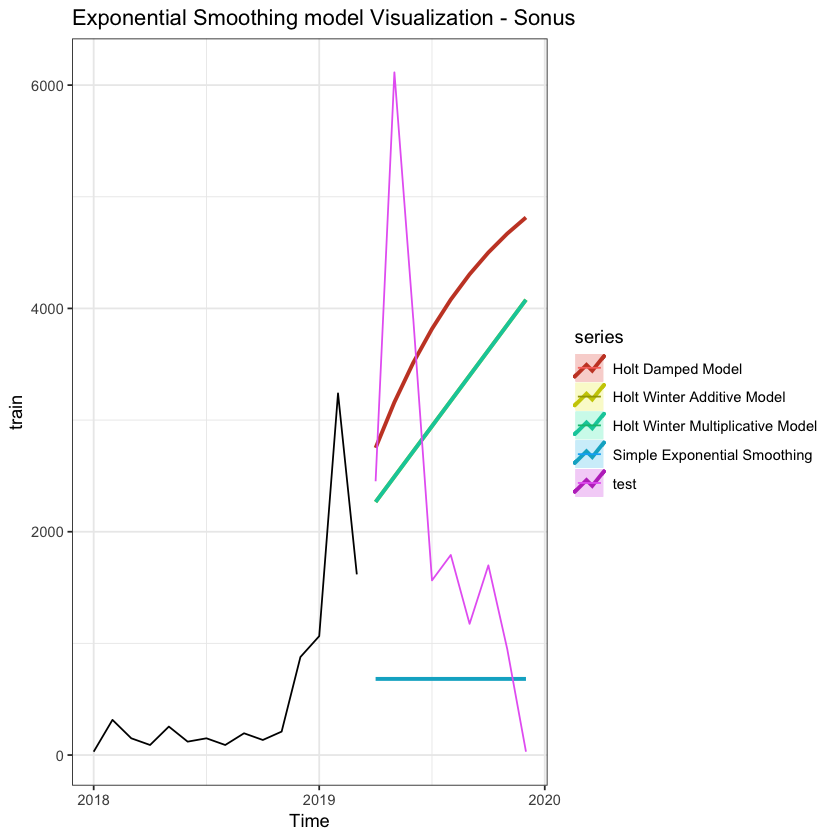

In [40]:
# Visualize forecasts (train & test)
autoplot(train)+
    autolayer(ses_model,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing model Visualization - Sonus")+
    autolayer(test)+theme_bw()

### Step8: Obtain the forecast Value

In [20]:
# obtain predicted value
ses_forecast = forecast(ses_model,h=9)
holt_forecast = forecast(holt_damp_model, h = 9)
hw_additive_forecast = forecast(hw_additive,h=9)
hw_multiplicative_forecast = forecast(hw_multiplicative,h=9)

In [21]:
ses_forecast

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       681.9267 -430.6647 1794.518 -1019.635 2383.488
May 2019       681.9267 -436.2138 1800.067 -1028.122 2391.975
Jun 2019       681.9267 -441.7355 1805.589 -1036.566 2400.420
Jul 2019       681.9267 -447.2302 1811.084 -1044.970 2408.823
Aug 2019       681.9267 -452.6983 1816.552 -1053.333 2417.186
Sep 2019       681.9267 -458.1402 1821.994 -1061.655 2425.509
Oct 2019       681.9267 -463.5563 1827.410 -1069.938 2433.792
Nov 2019       681.9267 -468.9468 1832.800 -1078.182 2442.036
Dec 2019       681.9267 -474.3122 1838.166 -1086.388 2450.241

In [22]:
holt_forecast

         Point Forecast    Lo 80    Hi 80       Lo 95     Hi 95
Apr 2019       2751.033 1714.974 3787.091  1166.51822  4335.547
May 2019       3160.021 1963.264 4356.779  1329.73912  4990.304
Jun 2019       3512.773 2051.641 4973.905  1278.16499  5747.381
Jul 2019       3817.021 2020.880 5613.161  1070.06113  6563.980
Aug 2019       4079.433 1906.682 6252.184   756.49702  7402.369
Sep 2019       4305.763 1733.898 6877.629   372.43501  8239.092
Oct 2019       4500.973 1519.354 7482.592   -59.01969  9060.965
Nov 2019       4669.340 1274.760 8063.920  -522.22154  9860.902
Dec 2019       4814.557 1008.557 8620.557 -1006.21810 10635.332

In [23]:
hw_additive_forecast

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       2266.469 1392.964 3139.974 930.5585 3602.379
May 2019       2492.849 1449.615 3536.083 897.3602 4088.338
Jun 2019       2719.230 1513.760 3924.699 875.6235 4562.835
Jul 2019       2945.610 1581.892 4309.328 859.9826 5031.237
Aug 2019       3171.990 1652.018 4691.962 847.3938 5496.587
Sep 2019       3398.371 1722.907 5073.834 835.9702 5960.771
Oct 2019       3624.751 1793.746 5455.756 824.4702 6425.032
Nov 2019       3851.131 1863.977 5838.285 812.0413 6890.221
Dec 2019       4077.512 1933.206 6221.817 798.0798 7356.943

In [24]:
hw_multiplicative_forecast

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       2266.469 1392.964 3139.974 930.5585 3602.379
May 2019       2492.849 1449.615 3536.083 897.3602 4088.338
Jun 2019       2719.230 1513.760 3924.699 875.6235 4562.835
Jul 2019       2945.610 1581.892 4309.328 859.9826 5031.237
Aug 2019       3171.990 1652.018 4691.962 847.3938 5496.587
Sep 2019       3398.371 1722.907 5073.834 835.9702 5960.771
Oct 2019       3624.751 1793.746 5455.756 824.4702 6425.032
Nov 2019       3851.131 1863.977 5838.285 812.0413 6890.221
Dec 2019       4077.512 1933.206 6221.817 798.0798 7356.943

### Step 9: Exponential Smoothing Model on the whole dataset

In [25]:
# Simple Exponential Smoothing Model on the whole dataset
library(forecast)
ses_model_all = ses(sales_ts,alpha=0.1, initial="simple")
ses_model_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       1391.956 -484.0366 3267.948 -1477.127 4261.038
Feb 2020       1391.956 -493.3932 3277.304 -1491.437 4275.348
Mar 2020       1391.956 -502.7036 3286.615 -1505.676 4289.587
Apr 2020       1391.956 -511.9685 3295.880 -1519.845 4303.756
May 2020       1391.956 -521.1885 3305.100 -1533.946 4317.857
Jun 2020       1391.956 -530.3644 3314.276 -1547.979 4331.890
Jul 2020       1391.956 -539.4966 3323.408 -1561.946 4345.857
Aug 2020       1391.956 -548.5858 3332.497 -1575.846 4359.758
Sep 2020       1391.956 -557.6327 3341.544 -1589.682 4373.594
Oct 2020       1391.956 -566.6377 3350.549 -1603.454 4387.366

In [26]:
# Holt's methods with damping on the whole dataset
holt_damp_model_all = holt(sales_ts,damped = T)
holt_damp_model_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       396.4011 -1285.974 2078.776 -2176.570 2969.372
Feb 2020       399.5944 -1636.162 2435.351 -2713.826 3513.015
Mar 2020       402.6114 -1933.746 2738.969 -3170.539 3975.761
Apr 2020       405.4619 -2197.066 3007.990 -3574.761 4385.685
May 2020       408.1551 -2435.794 3252.104 -3941.290 4757.600
Jun 2020       410.6997 -2655.769 3477.168 -4279.060 5100.459
Jul 2020       413.1038 -2860.837 3687.045 -4593.957 5420.164
Aug 2020       415.3752 -3053.689 3884.440 -4890.101 5720.852
Sep 2020       417.5213 -3236.295 4071.337 -5170.508 6005.551
Oct 2020       419.5490 -3410.147 4249.244 -5437.465 6276.563

In [27]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive_all = hw(sales_ts,seasonal = 'additive', damped = T)
hw_additive_all

         Point Forecast       Lo 80     Hi 80      Lo 95     Hi 95
Jan 2020       2519.586  -214.73430  5253.907 -1662.1961  6701.368
Feb 2020       4663.453  1929.13146  7397.774   481.6692  8845.236
Mar 2020       3015.002   280.67932  5749.324 -1166.7835  7196.787
Apr 2020       3820.633  1086.30888  6554.956  -361.1547  8002.420
May 2020       7451.352  4717.02655 10185.677  3269.5622 11633.141
Jun 2020       5221.668  2487.34061  7955.995  1039.8753  9403.460
Jul 2020       2848.048   113.71894  5582.378 -1333.7476  7029.844
Aug 2020       3049.776   315.44399  5784.108 -1132.0238  7231.575
Sep 2020       2407.867  -326.46765  5142.201 -1773.9369  6589.671
Oct 2020       2906.621   172.28291  5640.958 -1275.1880  7088.429
Nov 2020       2135.940  -598.40093  4870.281 -2045.8737  6317.754
Dec 2020       1192.188 -1542.15681  3926.533 -2989.6316  5374.008
Jan 2021       3657.681  -210.59885  7525.961 -2258.3425  9573.704
Feb 2021       5778.782  1910.49924  9647.065  -137.2461 11694

In [28]:
# Holt - winter Multiplicative
hw_multiplicative_all =  hw(sales_ts,seasonal = 'multiplicative', damped = T)
hw_multiplicative_all

         Point Forecast         Lo 80       Hi 80        Lo 95       Hi 95
Jan 2020    12431.13697    -26736.202    51598.48    -47470.14    72332.41
Feb 2020     6261.03942    -19843.536    32365.61    -33662.46    46184.54
Mar 2020     1443.33026     -7809.853    10696.51    -12708.19    15594.85
Apr 2020     2205.75224    -20910.323    25321.83    -33147.23    37558.74
May 2020     6284.53680   -103599.439   116168.51   -161768.50   174337.58
Jun 2020     1110.89669    -31716.150    33937.94    -49093.74    51315.53
Jul 2020      675.49230    -33606.369    34957.35    -51754.09    53105.07
Aug 2020      390.73310    -34462.142    35243.61    -52912.14    53693.61
Sep 2020      325.99591    -52545.818    53197.81    -80534.46    81186.46
Oct 2020      179.04091    -55472.064    55830.15    -84931.98    85290.06
Nov 2020      108.47761    -70662.329    70879.28   -108126.13   108343.09
Dec 2020      126.04857   -209426.530   209678.63   -320356.96   320609.06
Jan 2021     5875.48266  

### Step10: Model Forecast Visualization on the whole dataset

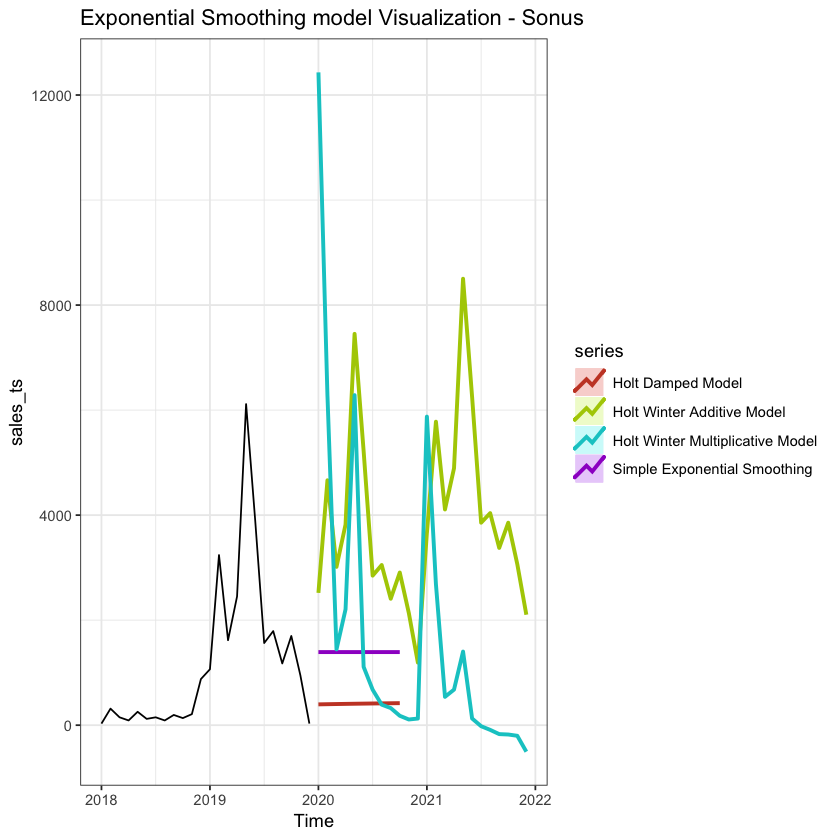

In [41]:
# Visualize forecasts (train & test)
autoplot(sales_ts)+
    autolayer(ses_model_all,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model_all, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive_all, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative_all, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing model Visualization - Sonus")+theme_bw()

### Step10: obtain forecast values on the whole dataset

In [30]:
# obtain predicted value
ses_forecast_all = forecast(ses_model_all)
holt_forecast_all = forecast(holt_damp_model_all)
hw_additive_forecast_all = forecast(hw_additive_all)
hw_multiplicative_forecast_all = forecast(hw_multiplicative_all)

In [31]:
ses_forecast_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       1391.956 -484.0366 3267.948 -1477.127 4261.038
Feb 2020       1391.956 -493.3932 3277.304 -1491.437 4275.348
Mar 2020       1391.956 -502.7036 3286.615 -1505.676 4289.587
Apr 2020       1391.956 -511.9685 3295.880 -1519.845 4303.756
May 2020       1391.956 -521.1885 3305.100 -1533.946 4317.857
Jun 2020       1391.956 -530.3644 3314.276 -1547.979 4331.890
Jul 2020       1391.956 -539.4966 3323.408 -1561.946 4345.857
Aug 2020       1391.956 -548.5858 3332.497 -1575.846 4359.758
Sep 2020       1391.956 -557.6327 3341.544 -1589.682 4373.594
Oct 2020       1391.956 -566.6377 3350.549 -1603.454 4387.366

In [32]:
holt_forecast_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       396.4011 -1285.974 2078.776 -2176.570 2969.372
Feb 2020       399.5944 -1636.162 2435.351 -2713.826 3513.015
Mar 2020       402.6114 -1933.746 2738.969 -3170.539 3975.761
Apr 2020       405.4619 -2197.066 3007.990 -3574.761 4385.685
May 2020       408.1551 -2435.794 3252.104 -3941.290 4757.600
Jun 2020       410.6997 -2655.769 3477.168 -4279.060 5100.459
Jul 2020       413.1038 -2860.837 3687.045 -4593.957 5420.164
Aug 2020       415.3752 -3053.689 3884.440 -4890.101 5720.852
Sep 2020       417.5213 -3236.295 4071.337 -5170.508 6005.551
Oct 2020       419.5490 -3410.147 4249.244 -5437.465 6276.563

In [33]:
hw_additive_forecast_all

         Point Forecast       Lo 80     Hi 80      Lo 95     Hi 95
Jan 2020       2519.586  -214.73430  5253.907 -1662.1961  6701.368
Feb 2020       4663.453  1929.13146  7397.774   481.6692  8845.236
Mar 2020       3015.002   280.67932  5749.324 -1166.7835  7196.787
Apr 2020       3820.633  1086.30888  6554.956  -361.1547  8002.420
May 2020       7451.352  4717.02655 10185.677  3269.5622 11633.141
Jun 2020       5221.668  2487.34061  7955.995  1039.8753  9403.460
Jul 2020       2848.048   113.71894  5582.378 -1333.7476  7029.844
Aug 2020       3049.776   315.44399  5784.108 -1132.0238  7231.575
Sep 2020       2407.867  -326.46765  5142.201 -1773.9369  6589.671
Oct 2020       2906.621   172.28291  5640.958 -1275.1880  7088.429
Nov 2020       2135.940  -598.40093  4870.281 -2045.8737  6317.754
Dec 2020       1192.188 -1542.15681  3926.533 -2989.6316  5374.008
Jan 2021       3657.681  -210.59885  7525.961 -2258.3425  9573.704
Feb 2021       5778.782  1910.49924  9647.065  -137.2461 11694

In [34]:
hw_multiplicative_forecast_all

         Point Forecast         Lo 80       Hi 80        Lo 95       Hi 95
Jan 2020    12431.13697    -26736.202    51598.48    -47470.14    72332.41
Feb 2020     6261.03942    -19843.536    32365.61    -33662.46    46184.54
Mar 2020     1443.33026     -7809.853    10696.51    -12708.19    15594.85
Apr 2020     2205.75224    -20910.323    25321.83    -33147.23    37558.74
May 2020     6284.53680   -103599.439   116168.51   -161768.50   174337.58
Jun 2020     1110.89669    -31716.150    33937.94    -49093.74    51315.53
Jul 2020      675.49230    -33606.369    34957.35    -51754.09    53105.07
Aug 2020      390.73310    -34462.142    35243.61    -52912.14    53693.61
Sep 2020      325.99591    -52545.818    53197.81    -80534.46    81186.46
Oct 2020      179.04091    -55472.064    55830.15    -84931.98    85290.06
Nov 2020      108.47761    -70662.329    70879.28   -108126.13   108343.09
Dec 2020      126.04857   -209426.530   209678.63   -320356.96   320609.06
Jan 2021     5875.48266  

### Step 11: obtain the accuracy value for the constructed models¶

In [35]:
# ses model
ses_accuracy = accuracy(ses_forecast,x=sales_ts) # accuracy on train and test sets
ses_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,434.6178,868.1597,435.6046,49.93912,51.03559,0.2407986,0.4552808,NA
Test set,1505.8511,2281.8067,1650.7237,-186.77165,296.13702,0.9125062,0.4213310,1.29807


In [36]:
# holt damped model
holt_damped_accuracy = accuracy(holt_forecast, x= sales_ts)
holt_damped_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,161.7702,660.089,349.6223,-29.57345,80.3387,0.1932683,-0.2214411,NA
Test set,-1768.9904,2860.586,2514.1473,-1888.41598,1901.4205,1.3897995,0.5801143,3.19259


In [37]:
# hw_additive
hw_additive_accuracy = accuracy(hw_additive_forecast, x = sales_ts)
hw_additive_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-165.2019,681.5994,501.1779,-242.3324,257.9036,0.2770469,-0.1392291,NA
Test set,-984.2124,2399.5898,2095.2019,-1574.0964,1595.7150,1.1582100,0.5575123,2.600392


In [38]:
# hw_multiplicative
hw_multiplicative_accuracy = accuracy(hw_multiplicative_forecast, x = sales_ts)
hw_multiplicative_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-165.2019,681.5994,501.1779,-242.3324,257.9036,0.2770469,-0.1392291,NA
Test set,-984.2124,2399.5898,2095.2019,-1574.0964,1595.7150,1.1582100,0.5575123,2.600392
